In [6]:
import atrack
from track_simulations import anomalous_diff_mixture
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### anomalous_diff_mixture: A script to simulate a population of tracks with multiple states

In [7]:
tracks, states = anomalous_diff_mixture(track_len=200, # Number of time points per track
                                        nb_tracks = 100, # Number of tracks
                                        LocErr=0.02, # localization error in x, y and z (even if not used)
                                        nb_states = 2, # number of states
                                        Fs = np.array([0.5, 0.5]), # Fractions of each state
                                        Ds = np.array([0.0, 0.05]), # Diffusion coefficients of each state
                                        nb_dims = 2,
                                        velocities = np.array([0.1, 0.0]), # Velocities coefficients of each state
                                        angular_Ds = np.array([0.0, 0.0]), # Rotational diffusion coefficient of the velocity for each state
                                        conf_forces = np.array([0.0, 0.2]), # Confinement factor for each state
                                        conf_Ds = np.array([0.0, 0.0]), # Diffusion coefficients of the potential well for each state
                                        conf_dists = np.array([0.0, 0.0]), # standard deviation of the initial distance between the first position and the first potential well center
                                        dt = 0.02, # time frame
                                        nb_sub_steps = 100, # number of sub-steps per step
                                        nb_blurring_sub_steps = 1) # Number of substeps used to account for dynamic localization errors

## Loading tracks with atrack.read_table

In [9]:
path = 'bacteria_tracks.csv'

lengths = np.arange(50, 100)

# The csv file needs to have these column names. If not, one can replace 'POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID' by the column names used in the csv file.
tracks, frames, opt_metrics = atrack.read_table(path, # path of the file to read or list of paths to read multiple files.
                                                lengths = lengths, # range of the number of time points in the tracks. Tracks with more time points than the maximum value are cut down.                                                dist_th = np.inf, # maximum distance allowed for consecutive positions 
                                                frames_boundaries = [-np.inf, np.inf], # min and max frame values allowed for peak detection
                                                fmt = 'csv', # format of the document to be red, 'csv' or 'pkl', one can also just specify a separator e.g. ' '. 
                                                colnames = ['POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID'], # List of the column names for the x positions, y positions, frame number and track ID.
                                                # if multiple columns are required to identify a track, the string used to identify the track ID can be replaced by a list of strings represening the column names e.g. ['TRACK_ID', 'Movie_ID']
                                                opt_colnames = [], # list of additional metrics to collect e.g. ['QUALITY', 'ID']
                                                remove_no_disp = True) # IF True, removes the tracks that shows no motion (some motion should be at least detected from the localization error)

for i in range(len(tracks)):
    tracks[i] = tracks[i]*0.12 # the csv track file gives the track positions in pixels so we must convert it in micrometers (here 1 pixel = 0.12 um)



atrack.read_table allows to load a csv file with column names 'POSITION_X', 'POSITION_Y', 'FRAME', 'TRACK_ID'. The rows represent the peaks and for each peak 'POSITION_X' and 'POSITION_Y' represent the spatial coordinates (floats), frame represent the time (integer of float) and peaks of the same track must share the same 'TRACK_ID' (integer). 

## Fitting single tracks to a Brownian motion model
Model assuming Brownian motion of diffusion length $d$ and with localization error. The diffusion length $d$, the diffusion coefficient $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$.

In [10]:

pd_params_Brownian = atrack.Brownian_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400, fitting_type = 'All')
print(pd_params_Brownian) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d
0        -4.537489  0.000046  0.253438
1        -7.731094  0.000039  0.261833
2         7.539203  0.000520  0.224398
3         1.706416  0.000112  0.237877
4        -3.437206  0.003901  0.250373
..             ...       ...       ...
80       23.156726  0.000017  0.215007
81       -5.735373  0.003109  0.249119
82        3.167722  0.001684  0.238080
83        7.480736  0.000016  0.232909
84        1.969475  0.000060  0.239552

[85 rows x 3 columns]


### saving the results as a csv file

In [11]:

savepath = 'Brownian_results.csv'
pd_params_Brownian.to_csv(savepath)


## Fitting single tracks to a confined motion model
Model assuming diffusion of diffusion length $d$, confined motion of confinement factor $l$ and with localization error. The potential well can move diffusively with a diffusion length $q$. Like for Brownian motion, diffusion lengths $d$, diffusion coefficients $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$. The confinement factor $l$ has no unit and increases with the force of the confinement. More precisely, during each time step the particle position is updated by $l\cdot(r-h)$ with $r$ the particle position and $h$ the position of the center of the potential well.

In [12]:

pd_params_Confined = atrack.Confined_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400)
print(pd_params_Confined) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d         q         l
0        -4.303108  0.000045  0.258887  0.000259  0.029670
1        -7.731112  0.000039  0.261833  0.248905  0.000001
2         7.539165  0.000519  0.224398  0.168428  0.000001
3         1.706390  0.000110  0.237877  0.188227  0.000001
4        -3.437204  0.003881  0.250374  0.239100  0.000001
..             ...       ...       ...       ...       ...
80       23.156597  0.000017  0.215007  0.157792  0.000001
81       -5.622733  0.003066  0.250794  0.250791  0.012159
82        3.316594  0.001674  0.240149  0.240149  0.016355
83        7.964812  0.000016  0.236546  0.000237  0.021765
84        1.976512  0.000059  0.239834  0.239819  0.001711

[85 rows x 5 columns]


In [13]:

savepath = 'Confined_results.csv'
pd_params_Confined.to_csv(savepath)


## Fitting single tracks to a directed motion model
Model assuming diffusion of diffusion length $d$, directed motion of initial speed $l$ and with localization error. The velocity of directed motion is allowed to change with time The potential well can move diffusively with a diffusion length $q$. Like for Brownian motion, diffusion lengths $d$, diffusion coefficients $D$ and the time step $\Delta t$ verify the following relathion: $d = \sqrt{2D\Delta t}$.

In [14]:

pd_params_Directed = atrack.Directed_fit(tracks, verbose = 0, Fixed_LocErr = False, Initial_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01}, nb_epochs = 400)
print(pd_params_Directed) # each row of pd_params correspond to the fitting for 1 track of tracks. e.g. pd_params.iloc[7] correspond to tracks[7]  


    Log_likelihood    LocErr         d         q         l  mean_speed
0        -4.537490  0.000048  0.253438  0.000005  0.000027    0.072065
1        -6.890757  0.000146  0.254207  0.014393  0.000064    0.163381
2         8.111520  0.000817  0.221064  0.000012  0.054488    0.084427
3         1.997765  0.000197  0.235556  0.000494  0.046757    0.075339
4        -3.378121  0.005290  0.249211  0.004710  0.000074    0.136191
..             ...       ...       ...       ...       ...         ...
80       25.086797  0.000048  0.202294  0.020699  0.093239    0.124383
81       -5.707492  0.003374  0.248720  0.002001  0.000024    0.090749
82        3.328340  0.002042  0.236961  0.003381  0.000023    0.129315
83        7.477709  0.000017  0.232911  0.000226  0.000020    0.088790
84        1.997971  0.000092  0.239126  0.002070  0.000068    0.126262

[85 rows x 6 columns]


In [15]:

savepath = 'Directed_results.csv'
pd_params_Directed.to_csv(savepath)


## Detecting significant confinement or directed motion
In order to verify if a given track is significantly directed (or significantly confined), we can compute the likelihood ratio $\rho$ which is the ratio between the likelihood assuming Brownian motion (null hypothesis) and the likelihood assuming directed (or confined) motion (alternative hypothesis). The likelihood ratio $\rho$ is similar to a p-value as $\rho <$ p-value of a given track. 

In [16]:
likelihood_ratio = np.exp(pd_params_Brownian['Log_likelihood'].values - pd_params_Directed['Log_likelihood'].values)
print(likelihood_ratio)

[1.00000058e+00 4.31565182e-01 5.64216693e-01 7.47254576e-01
 9.42626832e-01 1.00000048e+00 8.05940933e-01 4.18055516e-01
 2.02888868e-01 1.47980328e-01 9.99965248e-01 4.59613358e-01
 2.59335177e-01 9.95046504e-01 1.00059077e+00 1.00000079e+00
 8.96285433e-01 1.00008699e+00 9.12014137e-01 7.69369720e-02
 3.86186288e-01 9.48866221e-01 2.55838482e-18 8.67082234e-01
 1.86974478e-01 7.94255136e-01 5.98227193e-01 9.94620270e-01
 8.23564389e-01 6.42180701e-01 1.86446633e-02 1.19896337e-02
 9.49766188e-01 4.03425194e-01 1.00003035e+00 9.80216957e-01
 9.85674480e-01 3.02811781e-01 1.00003353e+00 3.80910843e-01
 1.00000383e+00 9.44763246e-01 4.86291392e-01 4.28632091e-01
 5.68980493e-01 1.22047108e-01 4.49103761e-01 3.83806018e-27
 1.00000243e+00 9.99998990e-01 1.52094201e-01 9.88604422e-01
 6.85022658e-02 1.00000241e+00 8.00759146e-02 1.00003700e+00
 1.77917327e-01 8.40716301e-01 1.00001465e+00 5.20795183e-23
 5.40927648e-01 1.00136738e+00 5.39526129e-01 6.97364327e-01
 8.35355562e-01 5.026149

Once the likelihood ratios has been computed for all tracks, we can plot them to obtain better insights on which tracks are significantly directed or confined: 

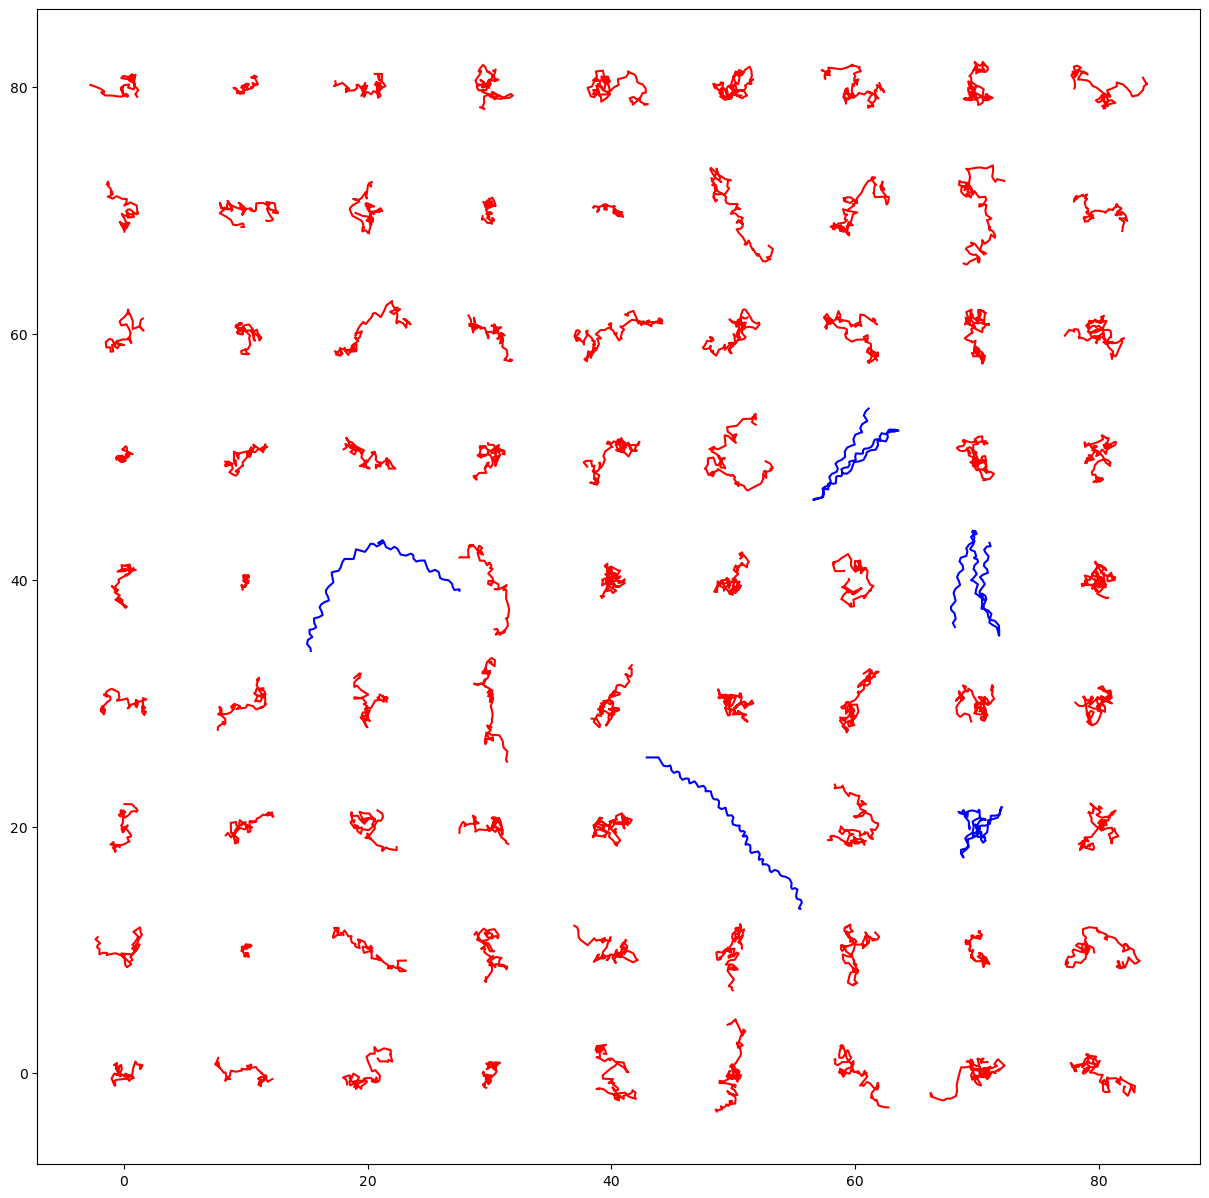

In [20]:

c = likelihood_ratio < 0.01 # array of booleans 
cs = ['r','b']
n = 9 # number of rows and columns to show in the plot

plt.figure(figsize = (15, 15))
lim = 10 # distance between tracks
for i in range(n):
    for j in range(n):
        track = tracks[i*n+j]
        track = track - np.mean(track,0, keepdims = True) + [[lim*i, lim*j]]
        plt.plot(track[:,0], track[:,1], alpha = 1, color = cs[c[i*n+j]*1])


Because we perform the test on many tracks and because a test using a threshold $k$ is expected to result in a faction $k$ of false positives, we must make sure that the fraction of significantly directed tracks is above that threshold.

In [21]:
p = 0.01
nb_success = np.sum(likelihood_ratio < p)
print('Fraction of significantly directed tracks: %s'%np.round(np.mean(likelihood_ratio < p), 5) + ', number of significantly directed tracks:', nb_success)

Fraction of significantly directed tracks: 0.05882, number of significantly directed tracks: 5


Here 9.3% is clearly higher than the threshold of 1%. To be more rigorous, we can perform a test on the number of tracks labeled as significantly directed. Under the null hypothesis, we expect the distribution of the number of tracks labeled as significantly directed to be a binomial distribution with $n$ trials and a success probability $p$. We can then comput the probability to have 4 significantly directed tracks with a threshold of 1% out of the 43 tracks.

In [22]:

n = len(tracks)
print('total number of tracks:', n)

import scipy
pvalue = 1-scipy.stats.binom.cdf(nb_success, n, p) # p-value = probability to have nb_success (here 4) or more significantly directed tracks out of n trials (here 43) with a probability of success per trial of p. 
print('p-value:', pvalue)


total number of tracks: 85
p-value: 0.00022266769240719686


The p-value is below 5%. We can therefore reject the null hypothesis with a high degree of confidence. 

## Fitting a population of tracks to a model with multiple states of motion
This model assums that each particle is in one out of multiple states of motion. The states of motion considered by the model are either directed or confined. NB: the directed and confined models also include Brownian motion (if $l=0$).

When the number of tracks is low, CPU computing can be faster than GPU compluting. To force the use of the CPU when a GPU is available, one can use `with tf.device('/CPU:0'):` 

In [23]:

with tf.device('/CPU:0'):
    likelihoods, pd_params_multi = atrack.multi_fit(tracks, verbose = 0, Fixed_LocErr = False, min_nb_states = 1, max_nb_states = 8, nb_epochs = 1000, batch_size = 2**11,
               Initial_confined_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01},
               Initial_directed_params = {'LocErr': 0.02, 'd': 0.1, 'q': 0.01, 'l': 0.01},
               )


Number of estimated clusters : 8


C:\Users\Franc\anaconda3\envs\PyTF\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


reduction phase: phase where we test the clustered states and remove the states with the smallest impact on the likelihood.
current number of states:  8
current number of states:  7 , likelihoods: 
                                                                     
number of states  1.0  2.0  3.0  4.0  5.0  6.0   7.000000   8.000000
Likelihood        0.0  0.0  0.0  0.0  0.0  0.0  13.959126  13.959468
current number of states:  7
current number of states:  6 , likelihoods: 
                                                                           
number of states  1.0  2.0  3.0  4.0  5.0   6.000000   7.000000   8.000000
Likelihood        0.0  0.0  0.0  0.0  0.0  13.945525  13.959126  13.959468
current number of states:  6
current number of states:  5 , likelihoods: 
                                                                        \
number of states  1.0  2.0  3.0  4.0   5.000000   6.000000   7.000000   
Likelihood        0.0  0.0  0.0  0.0  13.956612  13.945525  13.959126   


In [24]:
likelihoods.to_csv('likelihoods.csv')
for state in pd_params_multi.keys():
    pd_params_multi[state].to_csv('results_multi_%sstates.csv'%state)


We can then plot the likelihood depending on the number of states to select the best model. As mentionned in our article, the best number of states is when the likelihood plateaus. In this specific case, 4 to 5 states seem satisfying.

Text(0, 0.5, 'Likelihood')

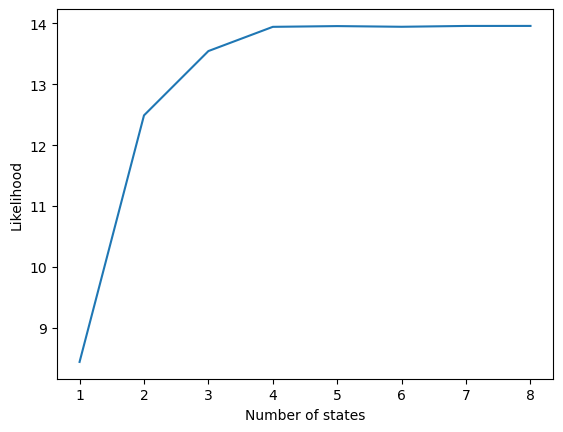

In [25]:
plt.figure()
plt.plot(likelihoods['number_of_states'], likelihoods['Likelihood'])
plt.xlabel('Number of states')
plt.ylabel('Likelihood')